In [1]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [2]:
root = '/content/drive/MyDrive/Hoc_Tap/CS410_MangNeural/Final_Project'

# Tổng quan:
- Ở trong bài này nhóm chúng tôi sẽ áp dụng thuật toán Nondominated Sorting Genetic Algorithm II (NSGA-II) để tối ưu hóa đa mục tiêu.
- Hai mục tiêu mà nhóm chúng tôi đã chọn để tối ưu hóa là ***test-accuracy*** và ***params***, cả hai mục tiêu đều được đánh giá bằng hàm benchmark NAS-Bench-201 trên 3 tập dữ liệu **cifar10-valid, cifar100, ImageNet16-120** tại **200** training epochs.
- Mục tiêu trong bài này là nhóm chúng tôi sẽ phát sinh ra các kiến trúc ngẫu nhiên, sau đó áp dụng thuật toán NSGA-II để tối đa hóa ***test-accuracy*** và tối thiểu hóa ***params*** nhằm tìm ra các kiến trúc tối ưu trong NAS-Bench-201. Kết quả của thuật toán trả về là một biên pareto front chứa các kiến trúc được cho là tối ưu như biểu đồ được vẽ ở bên dưới.
- Sau khi đã tìm ra được các kiến trúc tối ưu nằm trên biên pareto front, đồng thời nhóm chúng tôi cũng sẽ vẽ ra biên pareto front thật của hàm NAS-Bench-201 trên tập dữ liệu **cifar10-valid** tại **200** training epochs, sau đó nhóm sẽ so sánh và đánh giá giữa biên pareto front mà thuật toán NSGA-II tìm ra được với biên pareto front thật của NAS-Bench-201 bằng độ đo khoảng cách IGD.

# Khai báo thư viện cần thiết

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import json
from matplotlib.animation import FuncAnimation
import pandas as pd

# NAS_Benchmark_201

## Setup

1. Tải dữ liệu của NAS-Bench-201 tại link:
  *   [NATS-tss-v1_0-3ffb9-simple](https://drive.google.com/drive/folders/1FDXJ-nhBFHfm7pcA-wFnsBrmSFwTmK2h?usp=sharing)
2. Cài đặt các thư viện cần thiết:
  *   nats_bench (pip install nats_bench)

In [4]:
!pip install nats_bench

## Khai báo thư viện cần thiết

In [5]:
from nats_bench import create

## Khởi tạo API
* from nats_bench import create
* api = create('path_data', 'tss', fast_mode=True)

In [6]:
api = create(f'{root}/NAS_Benchmark/datasets/NATS-tss-v1_0-3ffb9-simple', 'tss', fast_mode=True)
api.verbose = False

[2021-12-31 14:09:22] Try to create the NATS-Bench (topology) api from /content/drive/MyDrive/Hoc_Tap/CS410_MangNeural/Final_Project/NAS_Benchmark/datasets/NATS-tss-v1_0-3ffb9-simple with fast_mode=True
[2021-12-31 14:11:34] Create NATS-Bench (topology) done with 0/15625 architectures avaliable.


## Mã hóa kiến trúc
-------------------------------------------------------------------------------
* Các kiến trúc được biểu diễn theo định dạng:

  '|operation\~0|+|operation\~0|operation\~1|+|operation\~0|operation\~1|operation~2|'

  với operation có thể là 1 trong 5 loại:
    * 'none'
    * 'skip_connect'
    * 'nor_conv_1x1'
    * 'nor_conv_3x3'
    * 'avg_pool_3x3'

* Example:
  * arch = '|none\~0|+|skip_connect\~0|none\~1|+|nor_conv_3x3\~0|nor_conv_1x1\~1|avg_pool_3x3\~2|'


In [7]:
def encode_arch(arch):
  operation_matrix = ['none', 'skip_connect', 'nor_conv_1x1', 'nor_conv_3x3', 'avg_pool_3x3']
  arch = f'|{operation_matrix[arch[0]]}~0|+|{operation_matrix[arch[1]]}~0|{operation_matrix[arch[2]]}~1|+|{operation_matrix[arch[3]]}~0|{operation_matrix[arch[4]]}~1|{operation_matrix[arch[5]]}~2|'

  return arch

## Hàm lấy giá trị hàm mục tiêu

-------------------------------------------------------------------------------
* Tổng cộng có 15625 kiến trúc trong NAS-Bench-201. Các thông tin được truy suất bằng số thứ tự của kiến trúc đó trong dữ liệu. Do đó, chúng ta cần chuyển từ dạng biểu diễn dạng 'string' sang số thứ tự (int).
* Syntax:
  
  idx = api.query_index_by_arch('kiến trúc biểu diễn ở dạng string')
* Example:

  idx = api.query_index_by_arch('|none\~0|+|skip_connect\~0|none\~1|+|nor_conv_3x3\~0|nor_conv_1x1\~1|avg_pool_3x3\~2|')
-------------------------------------------------------------------------------
* Syntax để lấy các giá trị accuracy (training, validation, testing)

  api.get_more_info(index, dataset=dataset, hp=hp)

  Trong đó:
    * index -> Vị trí của kiến trúc trong bộ benchmark (kiểu int)
    * dataset -> Bộ dữ liệu để huấn luyện và đánh giá kiến trúc. Có thể chọn 1 trong 3 giá trị (kiểu string):
      * 'cifar10-valid'
      * 'cifar100'
      * 'ImageNet16-120'
    * hp -> Số training epochs. Có thể chọn trong 2 giá trị (kiểu string):
      * '12'
      * '200'
* Kết quả trả về là 1 dictionary. Chúng ta có thể dễ dàng lấy những thông tin như mong muốn.

In [8]:
def get_obj_value( arch, dataset ):   
    idx = api.query_index_by_arch(arch)
    info = api.get_more_info(idx, dataset=dataset, hp='200', is_random=False)
    cost = api.get_cost_info(idx, dataset=dataset, hp='200')
    test_accuracy = np.round(info['test-accuracy'], 2)
    params = cost['params']
    
    return [params, test_accuracy]

## Hàm vét cạn toàn bộ kiến trúc trong NAS-Bench-201

In [9]:
def get_entire_arch(dataset):
  with open(f'{root}/NAS_Benchmark/datasets/NAS_201_{dataset}_200.txt', 'r') as fi:
    archs = fi.readlines()
    archs = [json.loads(arch.strip()) for arch in archs]
  
  return archs

## Hàm tính domination count cho các kiến trúc trong NAS-Bench-201

In [10]:
def calc_domination_count(archs):
  for arch in archs:
    arch['domination_count'] = 0
    for another_arch in archs:
      if another_arch['test_accuracy'] > arch['test_accuracy'] and another_arch['parameters'] <= arch['parameters']:
        arch['domination_count'] += 1
    
  return archs

## Hàm lấy biên pareto front thật của NAS-Bench-201

In [11]:
def get_bareto_front(dataset):
  archs = get_entire_arch(dataset)
  archs = calc_domination_count(archs)
  pf = []
  for arch in archs:
    if arch['domination_count'] == 0:
      pf.append([arch['parameters'], 100 -arch['test_accuracy']])
  pf = np.array(pf)

  return pf

# Hàm tạo file gif

In [12]:
def create_gif(file_name, dataset, all_pops, pf, igd, num_gens=100):
  def animate(i):
    igd_score = igd.do(all_pops[i].opt.get("F"))
    plt.title(f'Generation: {i}, IGD: {igd_score}')
    all_pops[generation] = all_pops[generation+i]
    scatter.set_offsets(all_pops[generation].opt.get("F"))
    return scatter,

  generation = 0
  fig, ax = plt.subplots(figsize=(15, 8))
  cp = ax.scatter(pf[:, 0], pf[:, 1], s=50, facecolors='none', edgecolor='red', label='pareto front of NAS-Bench-201')
  scatter = ax.scatter(all_pops[generation].opt.get("F")[:, 0], all_pops[generation].opt.get("F")[:, 1], s=50, facecolors='none', edgecolor='blue', label='pareto front of NSGA-II')
  plt.xlabel('Number of parameter (M)')
  plt.ylabel('Error (100 - Test accuracy)')
  plt.legend(loc='upper right')

  anim = FuncAnimation(fig, animate, interval=300, frames=num_gens, blit=True)
  anim.save(file_name, writer='pillow')

# Thuật toán NSGA-II

## Setup

In [13]:
!pip install -U pymoo

     |████████████████████████████████| 2.5 MB 3.9 MB/s 
     |████████████████████████████████| 239 kB 56.6 MB/s 


## Khai báo thư viện cần thiết

In [14]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.factory import get_sampling, get_crossover, get_mutation, get_termination
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.factory import get_performance_indicator

## Định nghĩa bài toán

In [15]:
class MyProblem(ElementwiseProblem):
    def __init__(self, dataset):
        super().__init__(n_var=6,
                         n_obj=2,
                         n_constr=0,
                         xl=0,
                         xu=4)
        self.dataset = dataset

    def _evaluate(self, x, out, *args, **kwargs):
        x = encode_arch(x)
        obj_values = get_obj_value(x, self.dataset)

        params = obj_values[0]
        error = 100 - obj_values[1]

        out["F"] = [params, error]

## Khởi tạo thuật toán

In [16]:
def init_algorithm(_pop_size, _n_offsprings, _sampling, _crossover, _mutation):
  algorithm = NSGA2(pop_size=_pop_size,
                    n_offsprings = _n_offsprings,
                    sampling=get_sampling(_sampling),
                    crossover=get_crossover(_crossover, prob=0.9),
                    mutation=get_mutation(_mutation, eta=20),
                    eliminate_duplicates=True)
  
  return algorithm

# Tối ưu hóa kiến trúc

## Chạy thuật toán NSGA-II

In [17]:
datasets = ['cifar10-valid', 'cifar100', 'ImageNet16-120']

In [18]:
res = {}
for dataset in datasets:
  print(f'\nDataset: {dataset}')
  problem = MyProblem(dataset)

  _pop_size = 40
  _n_offsprings = 40
  _sampling = 'int_random'
  _crossover = 'int_ux'
  _mutation = 'int_pm'
  algorithm = init_algorithm(_pop_size, _n_offsprings, _sampling, _crossover, _mutation)

  res[dataset] = minimize(problem, algorithm, termination=get_termination('n_gen', 100), seed=1, verbose=True, save_history=True)


Dataset: cifar10-valid
n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      40 |       5 |            - |            -
    2 |      80 |       7 |  0.004424779 |        ideal
    3 |     120 |       7 |  0.075117371 |        ideal
    4 |     160 |       8 |  0.053375196 |        ideal
    5 |     200 |       8 |  0.020833333 |        nadir
    6 |     240 |      11 |  0.072808321 |        ideal
    7 |     280 |      12 |  0.006476185 |            f
    8 |     320 |      12 |  0.023222061 |        ideal
    9 |     360 |      14 |  0.008633094 |        ideal
   10 |     400 |      13 |  0.001549530 |            f
   11 |     440 |      13 |  0.00000E+00 |            f
   12 |     480 |      14 |  0.003717148 |            f
   13 |     520 |      14 |  0.002553792 |            f
   14 |     560 |      13 |  0.001328168 |            f
   15 |     600 |      14 |  0.004338240 |            f
   16 |     640 |      14 |  0.000719424 |            f
   17 |     680 |      1

## Vẽ biên pareto front và tính khoảng cách IGD giữa biên pareton front thật của NAS-Bench-201 với biên pareto front do NSGA-II tìm được

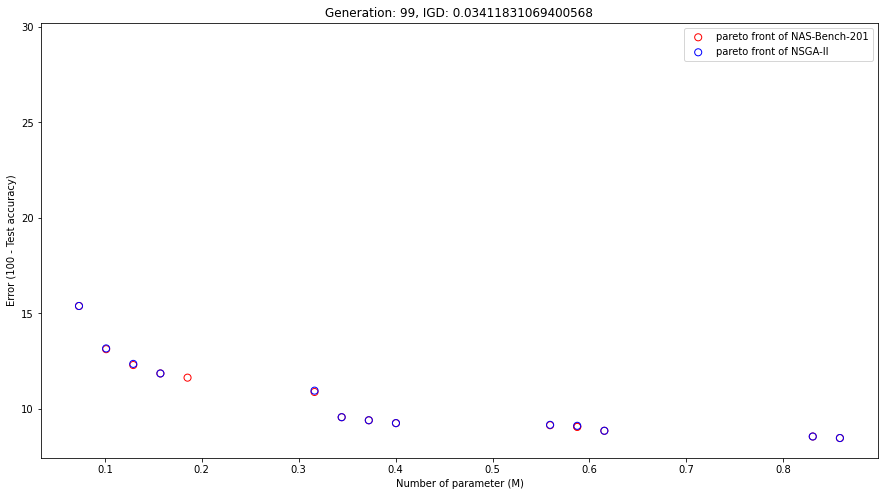

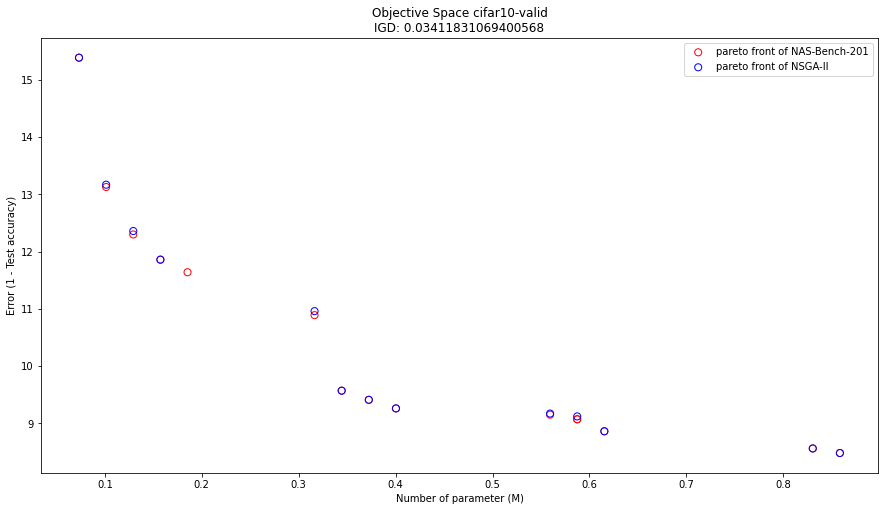

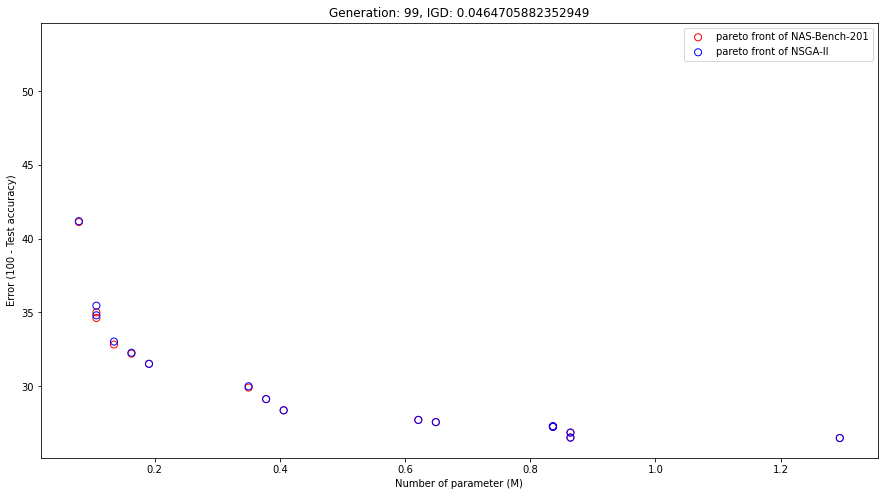

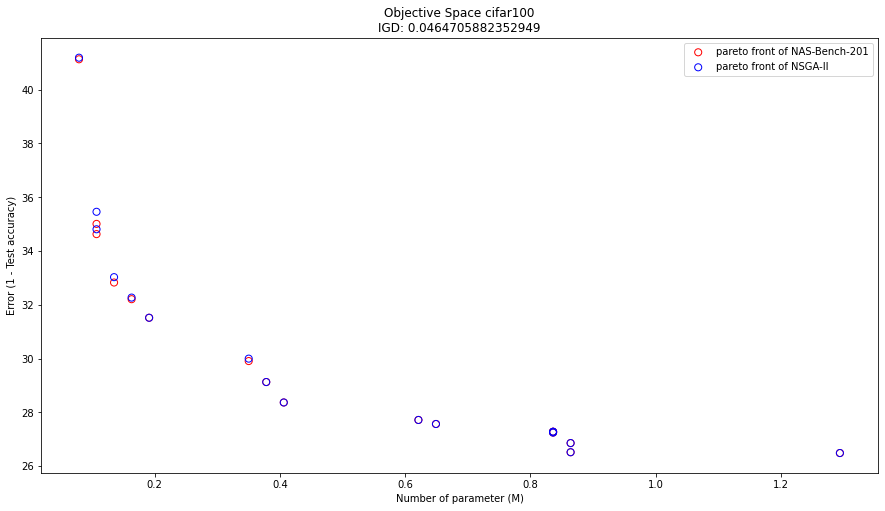

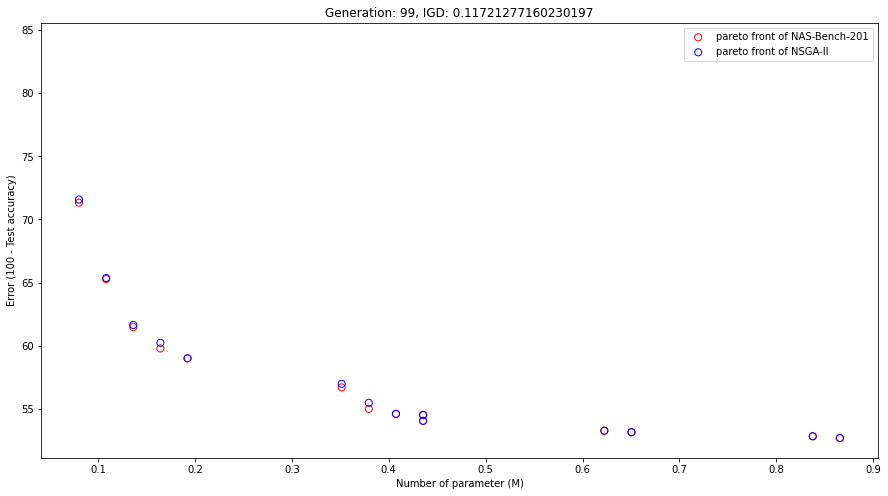

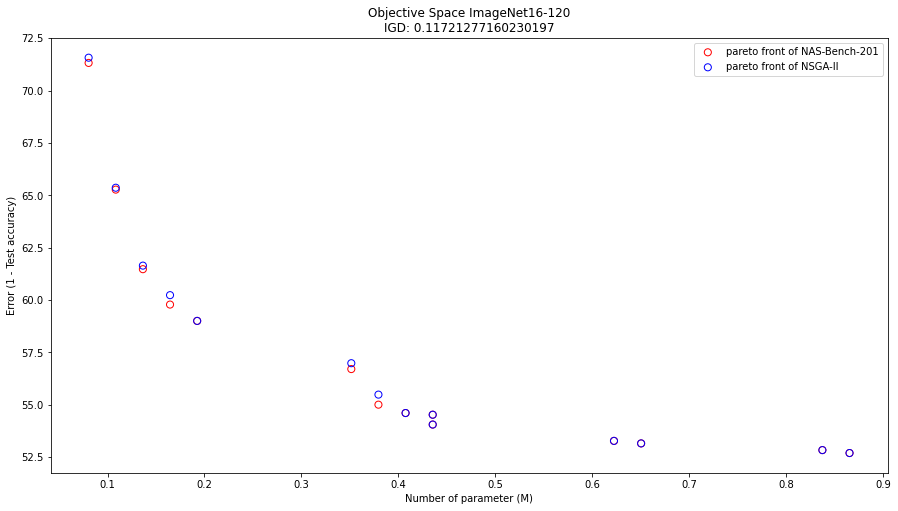

In [19]:
for dataset in datasets:
  pf = get_bareto_front(dataset)
  igd = get_performance_indicator("igd", pf)

  all_pops = res[dataset].history

  create_gif(f'{root}/report/MOOP_{dataset}.gif', dataset, all_pops, pf, igd, 100)

  fig, ax = plt.subplots(figsize=(15, 8))
  ax.scatter(pf[:, 0], pf[:, 1], s=50, facecolors='none', edgecolor='red', label='pareto front of NAS-Bench-201')
  ax.scatter(res[dataset].F[:, 0], res[dataset].F[:, 1], s=50, facecolors='none', edgecolor='blue', label='pareto front of NSGA-II')
  plt.title(f"Objective Space {dataset}\nIGD: {igd.do(res[dataset].F)}")
  plt.xlabel('Number of parameter (M)')
  plt.ylabel('Error (1 - Test accuracy)')
  plt.legend(loc='upper right')
  plt.savefig(f"{root}/report/MOOP_{dataset}.png")
  plt.show()